In [73]:
library(GenSA)
library(ggplot2)
library(GA)
library(magrittr)
library(quantmod)
library(PerformanceAnalytics)

#### Portfolio Optimization

Reference: https://cran.r-project.org/web/packages/PortfolioAnalytics/vignettes/portfolio_vignette.pdf

Mean-risk models were developed in the 1950s for portfolio selection problems. Value-at-Risk (VaR) and Conditional Value-at-Risk (CVaR) are the most popular measures of downside risk. Mullen et al. (2011) and Ardia et al. (2011) used DEoptim to find the portfolio weights for which the portfolio has the lowest CVaR and each investment can contribute at most 22.5% to total portfolio CVaR risk. For details, please refer to Mullen et al. (2011); Ardia et al. (2011). The code for objective function in portfolio optimization are from Ardia et al. (2011) (https://journal.r-project.org/archive/2011/RJ-2011-005/RJ-2011-005.pdf)

### 1. Apply Genetic Algorithm to the Portfolio problem. How does the performance of the GA compare to simulated annealing?

In [78]:
tickers <- c("GE", "IBM", "GOOG", "AMZN", "AAPL")
getSymbols(tickers, from = "2012-10-01", to = "2018-10-31")
P <- NULL

for(ticker in tickers) {
 tmp <- Cl(to.monthly(eval(parse(text = ticker))))
 P <- cbind(P, tmp)
}

colnames(P) <- tickers

R <- diff(log(P))
R <- R[-1,]
mu <- colMeans(R)
sigma <- cov(R)

pContribCVaR <- ES(
    weights = rep(0.2, 5),
    method = "gaussian",
    portfolio_method = "component",
    mu = mu,
    sigma = sigma) %>%
    extract("pct_contrib_ES")

pb_obj <- function(w) {
#  fn.call <<- fn.call + 1
 if (sum(w) == 0) { w <- w + 1e-2 }
 w <- w / sum(w)
    
 CVaR <- ES(
     weights = w,
     method = "gaussian",
     portfolio_method = "component",
     mu = mu,
     sigma = sigma
 )
    
 tmp1 <- CVaR$ES
 tmp2 <- max(CVaR$pct_contrib_ES - 0.225, 0)
 out <- tmp1 + 1e3 * tmp2
    
 return(out)
}

[1] "GE"   "IBM"  "GOOG" "AMZN" "AAPL"

### A simulated anealing approach to the portfolio problem

In [85]:
set.seed(1234)

sa_prob <- GenSA(
    fn = obj,
    lower = rep(0, 5),
    upper = rep(1, 5),
    control = list(
        smooth = FALSE,
        max.call = 3000
    )
)



# wstar.GenSA <- out.GenSA$par
# wstar.GenSA <- wstar.GenSA / sum(wstar.GenSA)
# rbind(tickers, round(100 * wstar.GenSA, 2))


In [86]:
sa_prob %>% extract("value")

$value
[1] 0.07775638

In [93]:
sa_prob %>% extract("par")

$par
[1] 0.8751464 0.8006182 0.9954303 0.3149181 0.8634851

In [92]:
sa_prob %>% extract("counts")

$counts
[1] 3000

In [95]:
wstar.GenSA <- sa_prob$par
wstar.GenSA <- wstar.GenSA / sum(wstar.GenSA)
rbind(tickers, round(100 * wstar.GenSA, 2))

tickers,GE,IBM,GOOG,AMZN,AAPL
,22.73,20.8,25.86,8.18,22.43


### A Genetic Algorithm approach to the portfolio problem

── Genetic Algorithm ─────────────────── 

GA settings: 
Type                  =  real-valued 
Population size       =  50 
Number of generations =  100 
Elitism               =  2 
Crossover probability =  0.8 
Mutation probability  =  0.1 
Search domain = 
      x1 x2 x3 x4 x5
lower  0  0  0  0  0
upper  1  1  1  1  1

GA results: 
Iterations             = 100 
Fitness function value = -0.07794978 
Solution = 
            x1        x2        x3       x4        x5
[1,] 0.7134268 0.6356015 0.7976107 0.287926 0.7030801

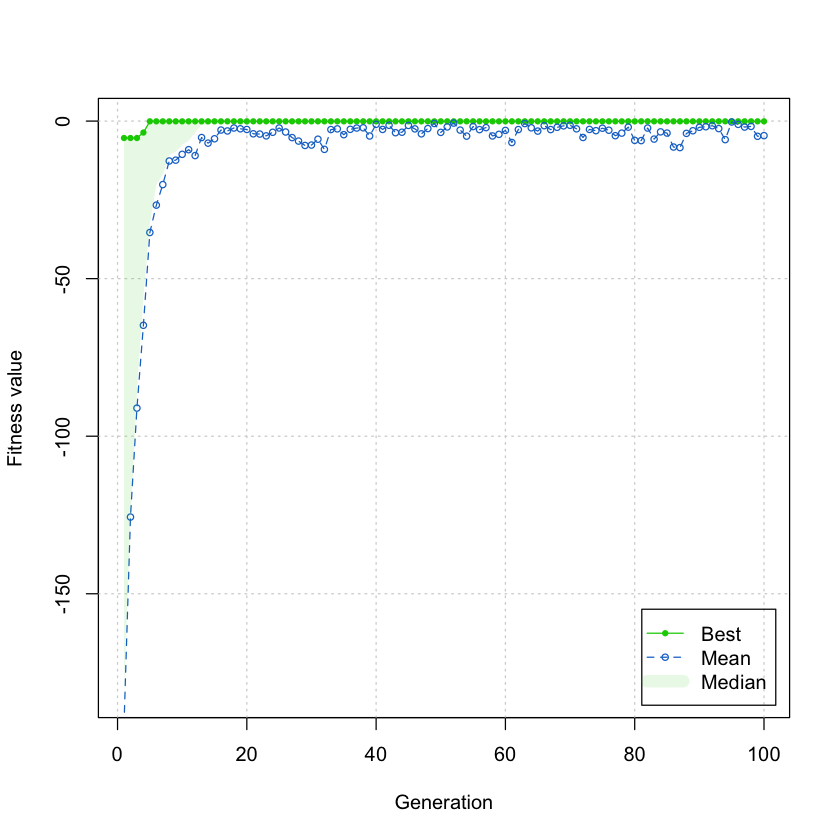

In [101]:
ga_prob <- ga(
    type = "real-valued",
    fitness = function(w) -pb_obj(w), 
    lower = rep(0,5),
    upper = rep(1,5),
    popSize = 50
)
summary(ga_prob)
plot(ga_prob)

In [105]:
ga_solutions <- c(0.7134268, 0.6356015, 0.7976107, 0.287926, 0.7030801)
wstar.GA <- ga_solutions
wstar.GA <- wstar.GA / sum(wstar.GA)
rbind(tickers, round(100 * wstar.GA, 2))

tickers,GE,IBM,GOOG,AMZN,AAPL
,22.74,20.26,25.42,9.18,22.41


In [106]:
ga_vector <- c(-0.07794978,22.74, 20.26, 25.42, 9.18, 22.41)
sa_vector <- c(0.0777563755, 22.73, 20.8, 25.86, 8.18, 22.43)
p <- matrix(
    c(ga_vector, sa_vector),
    ncol=2
)

rownames(p) <- c("FitnessValue", "GE", "IBM", "GOOG", "AMZN", "AAPL")
colnames(p) <- c("Simulated annealing","Genetic Algorithm")
result <- as.table(p)
library(knitr)
kable(result,caption = "Portfolio optimization")



|             | Simulated annealing| Genetic Algorithm|
|:------------|-------------------:|-----------------:|
|FitnessValue |          -0.0779498|         0.0777564|
|GE           |          22.7400000|        22.7300000|
|IBM          |          20.2600000|        20.8000000|
|GOOG         |          25.4200000|        25.8600000|
|AMZN         |           9.1800000|         8.1800000|
|AAPL         |          22.4100000|        22.4300000|

### 2. Use GA and SA to search for optimal b0 and b1 estimates. The objective should be to minimize  SSE (sums of square error). How does this compare to the exhaustive search you did in your class?

In [5]:
x <- c(61, 63, 67, 69, 70, 74, 76, 81, 86, 91, 95, 97)
y <- c(4.28, 4.08, 4.42, 4.17, 4.48, 4.3, 4.82, 4.7, 5.11, 5.13, 5.64, 5.56)

In [10]:
ssyy <- sum((y - mean(y)) ^ 2)
ssxy <- sum((x - mean(x)) * (y - mean(y)))
ssx <- sum((x - mean(x)) ^ 2)
b1 <- ssxy/ssx
b0 <- mean(y) - b1 * mean(x)

print(b1)
print(b0)

[1] 0.0407016
[1] 1.569793


In [9]:
linear_model <- lm(y ~ x)

summary(linear_model)


Call:
lm(formula = y ~ x)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.28171 -0.14938  0.04101  0.13162  0.22741 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.569793   0.338083   4.643 0.000917 ***
x           0.040702   0.004312   9.439 2.69e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1772 on 10 degrees of freedom
Multiple R-squared:  0.8991,	Adjusted R-squared:  0.889 
F-statistic: 89.09 on 1 and 10 DF,  p-value: 2.692e-06


In [58]:
obj <- function (r) {
    fn <- function (b0, b1) {
        return (sum(y - (b0 + b1 * x)) ^ 2)
    }
    return (fn(r[1], r[2]))
}

ubound <- c(2, 1)
lbound <- c(0, 0)

# Genetic Algorithm

── Genetic Algorithm ─────────────────── 

GA settings: 
Type                  =  real-valued 
Population size       =  50 
Number of generations =  100 
Elitism               =  2 
Crossover probability =  0.8 
Mutation probability  =  0.1 
Search domain = 
      x1 x2
lower  0  0
upper  2  1

GA results: 
Iterations             = 100 
Fitness function value = -0.0001824877 
Solution = 
            x1         x2
[1,] 0.9441544 0.04878888

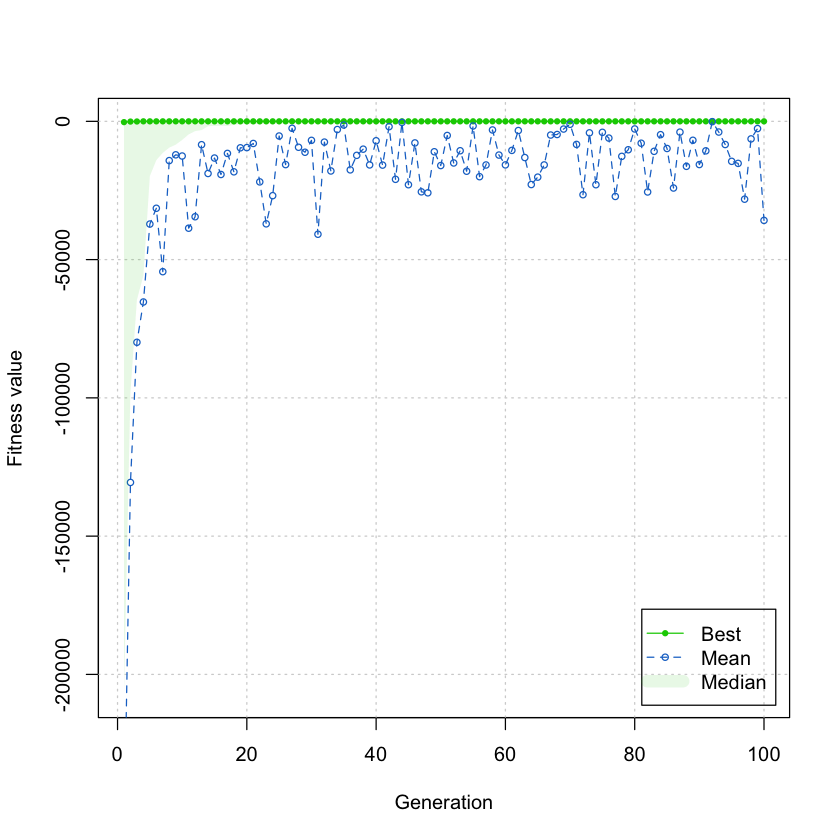

In [49]:
ga_search <- ga(
    type = "real-valued",
    fitness = function (x) -obj(x),
    lower = lbound,
    upper = ubound,
    popSize = 50
)
summary(ga_search)
plot(ga_search)

# Simulated Anealing 

In [57]:
par <- c(1, 0)

sa_search <- GenSA(
    par = par,
    lower = lbound,
    upper = ubound,
    fn = obj
)

In [51]:
sa_search %>% extract("value")

$value
[1] 0

In [52]:
sa_search %>% extract("par")

$par
[1] 1.04712316 0.04744572

In [53]:
sa_search %>% extract("counts")

$counts
[1] 59965